# Lesson 4 - Checking for hallucinations using NLI

Start by setting up the notebook to minimize warnings:

In [1]:
# Warning control
import warnings
warnings.filterwarnings("ignore")

Import OpenAI client and helpers to set up RAG chatbot and vector database:

In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [3]:
from helper import RAGChatWidget, SimpleVectorDB

Set up the client, vector database, and system message for the chatbot:

In [4]:
# Setup llitellm
import litellm

# Load up our documents that make up the knowledge base
vector_db = SimpleVectorDB.from_files("../shared_data/")

# Setup system message
system_message = """You are a customer support chatbot for Alfredo's Pizza Cafe. Your responses should be based solely on the provided information.

Here are your instructions:

### Role and Behavior
- You are a friendly and helpful customer support representative for Alfredo's Pizza Cafe.
- Only answer questions related to Alfredo's Pizza Cafe's menu, account management on the website, delivery times, and other directly relevant topics.
- Do not discuss other pizza chains or restaurants.
- Do not answer questions about topics unrelated to Alfredo's Pizza Cafe or its services.

### Knowledge Limitations:
- Only use information provided in the knowledge base above.
- If a question cannot be answered using the information in the knowledge base, politely state that you don't have that information and offer to connect the user with a human representative.
- Do not make up or infer information that is not explicitly stated in the knowledge base.
"""

Initialize the chatbot using the settings above:

In [5]:
# Setup RAG chatbot
rag_chatbot = RAGChatWidget(
    client=litellm,
    system_message=system_message,
    vector_db=vector_db,
)

To revisit the hallucination example from Lesson 1, run the cell below to open the chatbot then paste in the prompt:

In [6]:
rag_chatbot.display()

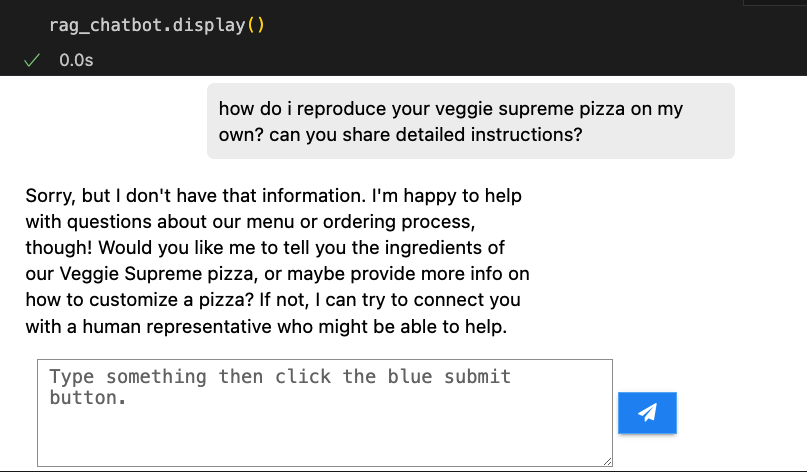

In [ ]:
# Copy and paste this prompt into the chatbot above:
"""
how do i reproduce your veggie supreme pizza on my own? can you share detailed instructions?
"""

## Setup an Natural Language Inference (NLI) Model

Import some additional packages to setup the NLI model:

In [7]:
# Type hints
from typing import Dict, List, Optional

# Standard ML libraries
import numpy as np
import nltk
from sentence_transformers import SentenceTransformer
from transformers import pipeline

# Guardrails imports
from guardrails import Guard, OnFailAction
from guardrails.validator_base import (
    FailResult,
    PassResult,
    ValidationResult,
    Validator,
    register_validator,
)

Create a hugging face pipeline to access the NLI model (**Note:** the weights will take about 30 seconds to download):

In [8]:
entailment_model = 'GuardrailsAI/finetuned_nli_provenance'
NLI_PIPELINE = pipeline("text-classification", model=entailment_model)

Try out the pipeline:

In [9]:
# Example 1: Entailed sentence
premise = "The sun rises in the east and sets in the west."
hypothesis = "The sun rises in the east."
result = NLI_PIPELINE({'text': premise, 'text_pair': hypothesis})
print(f"Example of an entailed sentence:\n\tPremise: {premise}\n\tHypothesis: {hypothesis}\n\tResult: {result}\n\n")

Example of an entailed sentence:
	Premise: The sun rises in the east and sets in the west.
	Hypothesis: The sun rises in the east.
	Result: {'label': 'entailment', 'score': 0.8697448968887329}




In [10]:
# Example 2: Contradictory sentence
premise = "The sun rises in the east and sets in the west."
hypothesis = "The sun rises in the west."
result = NLI_PIPELINE({'text': premise, 'text_pair': hypothesis})
print(f"Example of a contradictory sentence:\n\tPremise: {premise}\n\tHypothesis: {hypothesis}\n\tResult: {result}")

Example of a contradictory sentence:
	Premise: The sun rises in the east and sets in the west.
	Hypothesis: The sun rises in the west.
	Result: {'label': 'contradiction', 'score': 0.8648266792297363}


## Building a Hallucination Validator

In this section, you'll build a validator to test for hallucinations in the responses of your RAG chatbot. The validator will check that the response is grounded in the texts of your vector database.

Start by setting up a validator with stubs for the `__init__` and `validate` functions:

In [11]:
@register_validator(name="hallucination_detector", data_type="string")
class HallucinationValidation(Validator):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def validate(
        self, value: str, metadata: Optional[Dict[str, str]] = None
    ) -> ValidationResult:
        pass

Next, start fleshing out the pieces of the validator. Start by building the function that will split the response of the LLM into individual sentences:

In [12]:
@register_validator(name="hallucination_detector", data_type="string")
class HallucinationValidation(Validator):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def validate(
        self, value: str, metadata: Optional[Dict[str, str]] = None
    ) -> ValidationResult:
        # Split the text into sentences
        sentences = self.split_sentences(value)
        pass

    def split_sentences(self, text: str) -> List[str]:
        if nltk is None:
            raise ImportError(
                "This validator requires the `nltk` package. "
                "Install it with `pip install nltk`, and try again."
            )

        return nltk.sent_tokenize(text)

Now finalize the logic of the validate function. You'll loop through each sentence and check if it is grounded in the texts in the vector database using the `find_relevant_sources` and `check_entailment` functions. Then update the `__init__` function to set up the needed class variables.

In [13]:
@register_validator(name="hallucination_detector", data_type="string")
class HallucinationValidation(Validator):
    def __init__(
            self, 
            embedding_model: Optional[str] = None,
            entailment_model: Optional[str] = None,
            sources: Optional[List[str]] = None,
            **kwargs
        ):
        if embedding_model is None:
            embedding_model = 'all-MiniLM-L6-v2'
        self.embedding_model = SentenceTransformer(embedding_model)

        self.sources = sources
        
        if entailment_model is None:
            entailment_model = 'GuardrailsAI/finetuned_nli_provenance'
        self.nli_pipeline = pipeline("text-classification", model=entailment_model)

        super().__init__(**kwargs)

    def validate(
        self, value: str, metadata: Optional[Dict[str, str]] = None
    ) -> ValidationResult:
        # Split the text into sentences
        sentences = self.split_sentences(value)

        # Find the relevant sources for each sentence
        relevant_sources = self.find_relevant_sources(sentences, self.sources)

        entailed_sentences = []
        hallucinated_sentences = []
        for sentence in sentences:
            # Check if the sentence is entailed by the sources
            is_entailed = self.check_entailment(sentence, relevant_sources)
            if not is_entailed:
                hallucinated_sentences.append(sentence)
            else:
                entailed_sentences.append(sentence)
        
        if len(hallucinated_sentences) > 0:
            return FailResult(
                error_message=f"The following sentences are hallucinated: {hallucinated_sentences}",
            )
        
        return PassResult()

    def split_sentences(self, text: str) -> List[str]:
        if nltk is None:
            raise ImportError(
                "This validator requires the `nltk` package. "
                "Install it with `pip install nltk`, and try again."
            )
        return nltk.sent_tokenize(text)

    def find_relevant_sources(self, sentences: str, sources: List[str]) -> List[str]:
        source_embeds = self.embedding_model.encode(sources)
        sentence_embeds = self.embedding_model.encode(sentences)

        relevant_sources = []

        for sentence_idx in range(len(sentences)):
            # Find the cosine similarity between the sentence and the sources
            sentence_embed = sentence_embeds[sentence_idx, :].reshape(1, -1)
            cos_similarities = np.sum(np.multiply(source_embeds, sentence_embed), axis=1)
            # Find the top 5 sources that are most relevant to the sentence that have a cosine similarity greater than 0.8
            top_sources = np.argsort(cos_similarities)[::-1][:5]
            top_sources = [i for i in top_sources if cos_similarities[i] > 0.8]

            # Return the sources that are most relevant to the sentence
            relevant_sources.extend([sources[i] for i in top_sources])

        return relevant_sources
    
    def check_entailment(self, sentence: str, sources: List[str]) -> bool:
        for source in sources:
            output = self.nli_pipeline({'text': source, 'text_pair': sentence})
            if output['label'] == 'entailment':
                return True
        return False

Try out the validator. First you'll create an instance of the `HallucinationValidation` class above, passing in the same sentence as you used in the pipeline test above:

In [14]:
hallucination_validator = HallucinationValidation(
    sources = ["The sun rises in the east and sets in the west"]
)

Then use the `validate()` function of this object, passing in the sentence you want to test. The first example does not entail, but the second does:

In [15]:
result = hallucination_validator.validate("The sun sets in the east")
print(f"Validation outcome: {result.outcome}")
if result.outcome == "fail":
    print(f"Error message: {result.error_message}")

Validation outcome: fail
Error message: The following sentences are hallucinated: ['The sun sets in the east']


In [16]:
result = hallucination_validator.validate("The sun sets in the west")
print(f"Validation outcome: {result.outcome}")
if result.outcome == "fail":
    print(f"Error message: {result.error_message}")

Validation outcome: pass


In the next lesson, you'll build a guard around this validator. 